In [1]:
import torch
import pytorch3d
import torch_geometric
import warnings
warnings.filterwarnings('ignore')

print("PyTorch:", torch.__version__)
print("MPS:", torch.backends.mps.is_available())
print("PyTorch3D:", pytorch3d.__version__)
print("Torch Geometric", torch_geometric.__version__)

PyTorch: 2.7.1
MPS: True
PyTorch3D: 0.7.8
Torch Geometric 2.6.1


In [19]:
%load_ext autoreload
%autoreload 2

# --- Import Dependencies ---
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pytorch3d.utils import ico_sphere
from pytorch3d.structures import Meshes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from datetime import datetime
from pathlib import Path
import re
import glob

from hiegan.config import Config
from hiegan.dataset import ShapeNetMVDataset
from hiegan.utils.collate import MeshCollator
from hiegan.models.generator import HIEGenerator
from hiegan.models.discriminator import PointCloudDiscriminator
from hiegan.utils.loss_utils import HIEGANLoss
from hiegan.utils.mesh_utils import mesh_to_pointcloud
from hiegan.train import train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### --- Configuration ---

In [20]:
cfg = Config()

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_device()
print(f"🔧 Using device: {device}")

🔧 Using device: cpu


### --- Dataset Loading ---

In [21]:
# Load dataset
print("\n📁 Loading Dataset...")

try:
    ds = ShapeNetMVDataset(
        cfg.DATASET_ROOT,
        image_size=cfg.IMAGE_SIZE,
        multi_view=cfg.MULTI_VIEW
    )
    print(f"✅ Dataset loaded: {len(ds)} samples")

    # Create collator with single device
    collator = MeshCollator(device=device)

    # Create DataLoader - FIXED pin_memory logic
    dataloader = DataLoader(
        ds,
        batch_size=cfg.BATCH_SIZE,
        shuffle=True,
        num_workers=cfg.NUM_WORKERS,
        collate_fn=collator,
        pin_memory=True if device.type == 'cuda' else False  # Now works correctly
    )
    print(f"✅ DataLoader created with batch size: {cfg.BATCH_SIZE}")

except Exception as e:
    print(f"❌ Dataset loading failed: {e}")
    raise e


📁 Loading Dataset...
Dataset loaded: 936 samples
✅ Dataset loaded: 936 samples
✅ DataLoader created with batch size: 8


In [22]:
# --- Test DataLoader ---
print("\n🔍 Testing DataLoader...")
try:
    sample_images, sample_meshes, sample_metadata = next(iter(dataloader))
    print(f"✅ Batch loaded successfully!")
    print(f"   - Images shape: {sample_images.shape}, device: {sample_images.device}")
    print(f"   - Meshes device: {sample_meshes.device}")
    print(f"   - Sample: {sample_metadata[0]['class_id']}/{sample_metadata[0]['obj_id']}")

except Exception as e:
    print(f"❌ DataLoader test failed: {e}")
    raise e


🔍 Testing DataLoader...
✅ Batch loaded successfully!
   - Images shape: torch.Size([8, 3, 224, 224]), device: cpu
   - Meshes device: cpu
   - Sample: 03001627/4fad9d9b2c73cccccf0517eac2f2d331


In [23]:
# --- Visualization Functions ---
def denormalize_image(img_tensor):
    """Convert normalized tensor back to displayable image"""
    img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
    img_np = (img_np + 1.0) / 2.0  # Undo normalization [-1,1] -> [0,1]
    return np.clip(img_np, 0, 1)

In [24]:
def visualize_single_sample(images, meshes, metadata, sample_idx=0):
    """Visualize a single sample: image + mesh + point cloud"""

    # Get data for this sample
    img_tensor = images[sample_idx] if len(images.shape) == 4 else images
    if len(img_tensor.shape) == 4:  # Multi-view case
        img_tensor = img_tensor[0]  # Take first view

    mesh = meshes[sample_idx] if len(meshes) > 1 else meshes
    meta = metadata[sample_idx] if isinstance(metadata, list) else metadata

    # Create figure
    fig = plt.figure(figsize=(18, 6))

    # 1. Input Image
    ax1 = plt.subplot(1, 3, 1)
    img_display = denormalize_image(img_tensor)
    ax1.imshow(img_display)
    ax1.set_title(f'Input Image\nClass: {meta["class_id"]}\nObject: {meta["obj_id"]}', fontsize=12)
    ax1.axis('off')

    # 2. Mesh Vertices (3D scatter)
    vertices = mesh.verts_list()[0].cpu().numpy()
    faces = mesh.faces_list()[0].cpu().numpy()
    ax2 = plt.subplot(1, 3, 2, projection='3d')
    # Sample vertices for visualization (if too many)
    if len(vertices) > 2000:
        indices = np.random.choice(len(vertices), 2000, replace=False)
        vertices_sample = vertices[indices]
    else:
        vertices_sample = vertices

    ax2.scatter(vertices_sample[:, 0], vertices_sample[:, 1], vertices_sample[:, 2],
               c=vertices_sample[:, 2], cmap='viridis', s=1, alpha=0.7)
    ax2.set_title(f'Mesh Vertices\n{vertices.shape[0]} vertices, {faces.shape[0]} faces', fontsize=12)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # 3. Sampled Point Cloud
    ax3 = plt.subplot(1, 3, 3, projection='3d')
    try:
        # Sample points from mesh surface
        sampled_points = mesh_to_pointcloud(mesh, num_samples=2048)
        points_np = sampled_points[0].cpu().numpy()

        ax3.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2],
                   c=points_np[:, 2], cmap='plasma', s=1, alpha=0.8)
        ax3.set_title(f'Sampled Point Cloud\n{points_np.shape[0]} points', fontsize=12)

    except Exception as e:
        print(f"Point cloud sampling failed: {e}")
        # Fallback: use mesh vertices
        ax3.scatter(vertices_sample[:, 0], vertices_sample[:, 1], vertices_sample[:, 2],
                   c=vertices_sample[:, 2], cmap='plasma', s=1, alpha=0.8)
        ax3.set_title('Mesh Vertices (Fallback)', fontsize=12)

    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    # Make all 3D plots have equal aspect ratio
    for ax in [ax2, ax3]:
        max_range = np.array([vertices[:, 0].max()-vertices[:, 0].min(),
                             vertices[:, 1].max()-vertices[:, 1].min(),
                             vertices[:, 2].max()-vertices[:, 2].min()]).max() / 2.0
        mid_x = (vertices[:, 0].max()+vertices[:, 0].min()) * 0.5
        mid_y = (vertices[:, 1].max()+vertices[:, 1].min()) * 0.5
        mid_z = (vertices[:, 2].max()+vertices[:, 2].min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.tight_layout()
    plt.show()

    # Print detailed info
    print(f"\n--- Sample {sample_idx} Details ---")
    print(f"Class ID: {meta['class_id']}")
    print(f"Object ID: {meta['obj_id']}")
    print(f"Number of views: {meta.get('num_views', 'Unknown')}")
    print(f"Image shape: {img_tensor.shape}")
    print(f"Mesh vertices: {vertices.shape[0]:,}")
    print(f"Mesh faces: {faces.shape[0]:,}")
    print(f"Vertex coordinate range: [{vertices.min():.3f}, {vertices.max():.3f}]")


In [25]:
def visualize_batch_overview(images, meshes, metadata, max_samples=4):
    """Show overview of multiple samples in a batch"""
    num_samples = min(len(metadata), max_samples, images.shape[0])

    fig, axes = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)

    for i in range(num_samples):
        # Top row: Images
        img_tensor = images[i] if len(images.shape) == 4 else images
        if len(img_tensor.shape) == 4:  # Multi-view
            img_tensor = img_tensor[0]

        img_display = denormalize_image(img_tensor)
        axes[0, i].imshow(img_display)
        axes[0, i].set_title(f'Sample {i}\n{metadata[i]["class_id"][:10]}...', fontsize=10)
        axes[0, i].axis('off')

        # Bottom row: Point clouds
        mesh = meshes[i] if len(meshes) > 1 else meshes

        axes[1, i] = plt.subplot(2, num_samples, num_samples + i + 1, projection='3d')

        try:
            # Sample point cloud
            points = mesh_to_pointcloud(mesh, num_samples=1024)
            points_np = points[0].cpu().numpy()

            axes[1, i].scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2],
                             c=points_np[:, 2], cmap='viridis', s=2, alpha=0.8)
            axes[1, i].set_title(f'Point Cloud {i}', fontsize=10)

        except Exception as e:
            # Fallback: use vertices
            vertices = mesh.verts_list()[0].cpu().numpy()
            if len(vertices) > 1000:
                indices = np.random.choice(len(vertices), 1000, replace=False)
                vertices = vertices[indices]

            axes[1, i].scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2],
                             c=vertices[:, 2], cmap='viridis', s=2, alpha=0.8)
            axes[1, i].set_title(f'Vertices {i}', fontsize=10)

    plt.tight_layout()
    plt.show()



🎨 Visualizing Sample Data...

--- DETAILED SAMPLE VIEW ---


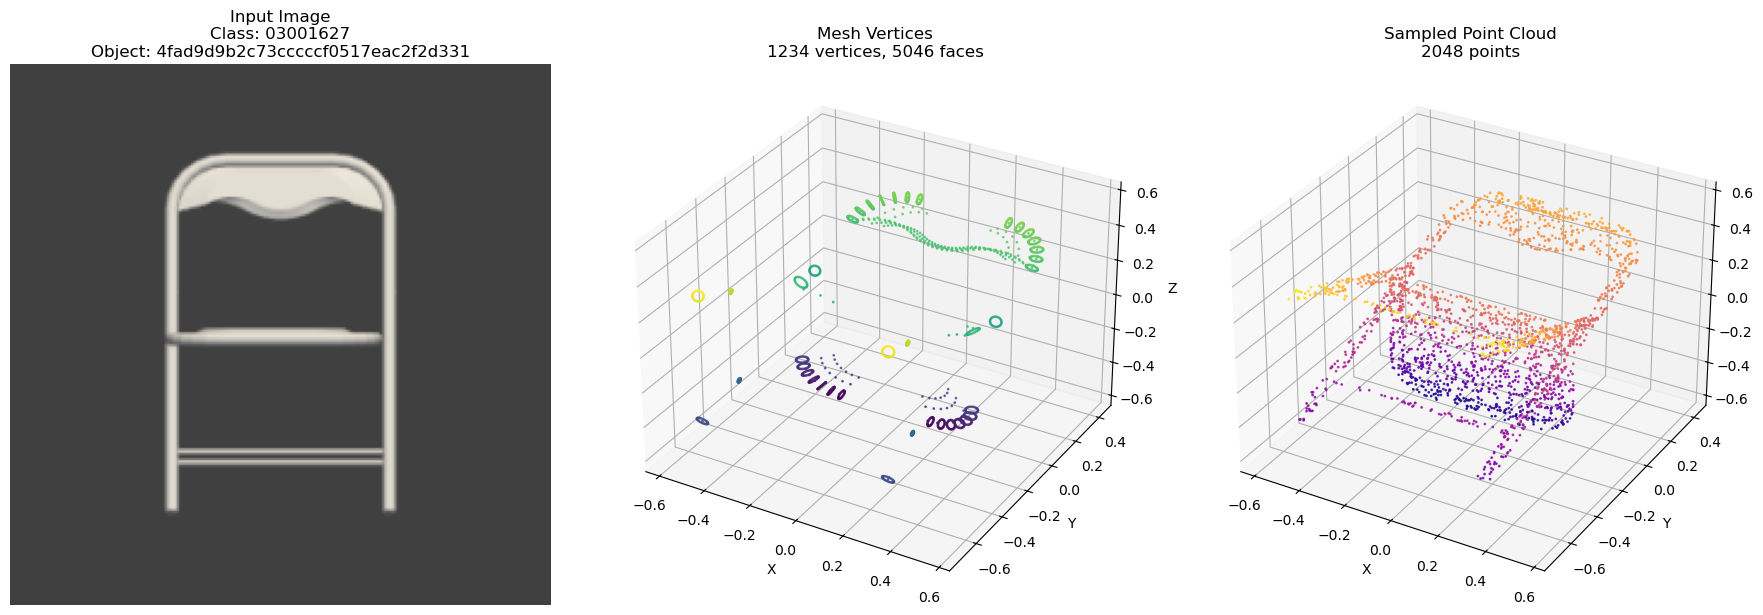


--- Sample 0 Details ---
Class ID: 03001627
Object ID: 4fad9d9b2c73cccccf0517eac2f2d331
Number of views: 16
Image shape: torch.Size([3, 224, 224])
Mesh vertices: 1,234
Mesh faces: 5,046
Vertex coordinate range: [-0.800, 0.505]
✅ Detailed visualization successful!

--- BATCH OVERVIEW ---


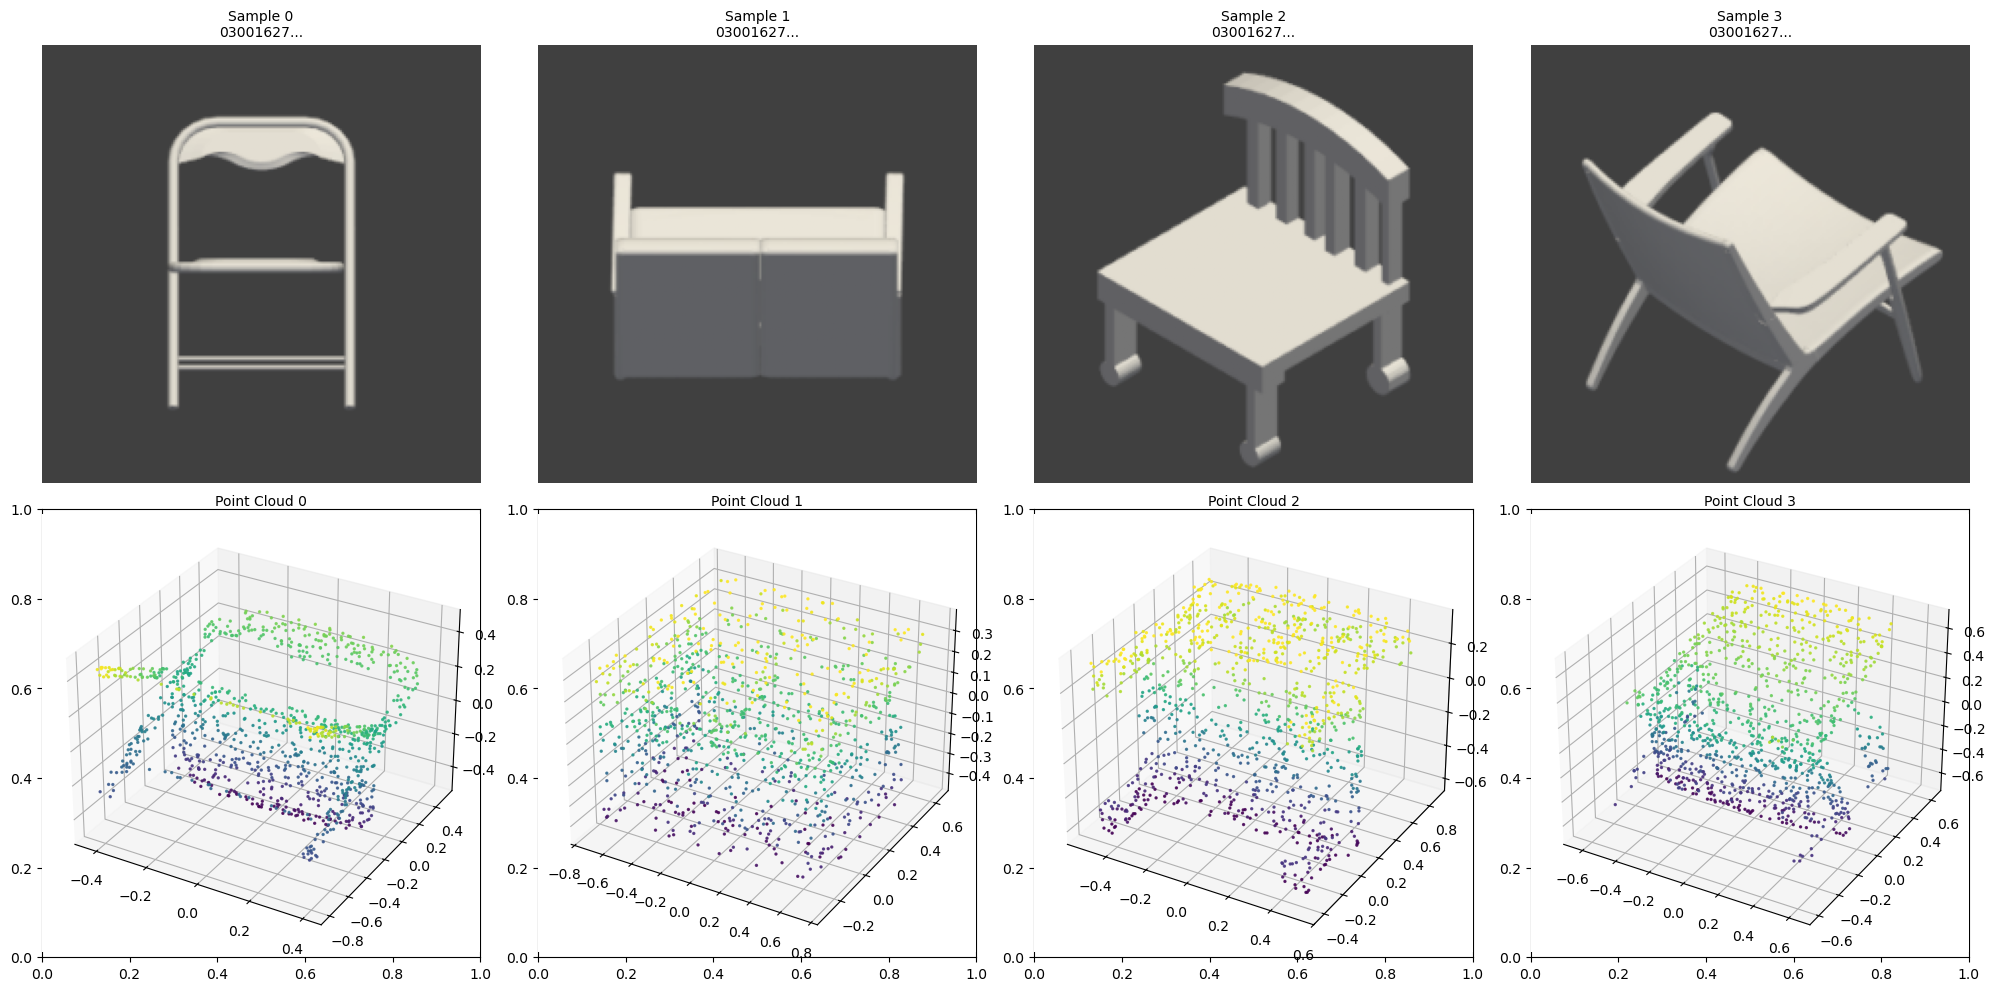

✅ Batch overview successful!

📊 DATASET STATISTICS
----------------------------------------


In [26]:
# --- Visualize Samples ---
print("\n🎨 Visualizing Sample Data...")

# 1. Show detailed view of first sample
print("\n--- DETAILED SAMPLE VIEW ---")
try:
    visualize_single_sample(sample_images, sample_meshes, sample_metadata, sample_idx=0)
    print("✅ Detailed visualization successful!")
except Exception as e:
    print(f"❌ Detailed visualization failed: {e}")

# 2. Show overview of multiple samples
print("\n--- BATCH OVERVIEW ---")
try:
    visualize_batch_overview(sample_images, sample_meshes, sample_metadata, max_samples=4)
    print("✅ Batch overview successful!")
except Exception as e:
    print(f"❌ Batch overview failed: {e}")

# --- Dataset Statistics ---
print("\n📊 DATASET STATISTICS")
print("-" * 40)

### --- Model Initialization ---

In [27]:
print("\n🤖 Initializing HIE-GAN Model...")

try:
    # --- Initialize Models ---
    generator = HIEGenerator(latent_dim=cfg.LATENT_DIM).to(device)
    discriminator = PointCloudDiscriminator().to(device)

    print(f"✅ Models initialized on {device}")
    print(f"   - Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
    print(f"   - Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

    # --- Initialize Optimizers ---
    g_optimizer = Adam(generator.parameters(), lr=cfg.LR, betas=(0.5, 0.999))
    d_optimizer = Adam(discriminator.parameters(), lr=cfg.LR, betas=(0.5, 0.999))

    print(f"✅ Optimizers initialized with learning rate: {cfg.LR}")

    # --- Initialize Loss Function ---
    criterion = HIEGANLoss(
        chamfer_weight=cfg.CHAMFER_WEIGHT,
        sdf_weight=cfg.IMPLICIT_WEIGHT,
        explicit_weight=cfg.EXPLICIT_WEIGHT,
        fusion_weight=1.0
    )

    print(f"✅ Loss function initialized")

    # --- Create Template Mesh ---
    template_mesh = ico_sphere(level=2, device=device)
    template_verts = template_mesh.verts_list()[0]
    template_faces = template_mesh.faces_list()[0]
    template_edges = template_mesh.edges_packed().t().contiguous()

    print(f"✅ Template mesh created:")
    print(f"   - Vertices: {template_verts.shape[0]:,}")
    print(f"   - Faces: {template_faces.shape[0]:,}")
    print(f"   - Edges: {template_edges.shape[1]:,}")

    # --- Test Single Sample Generation ---
    print("\n🎯 Testing model forward pass...")

    def test_single_sample():
        generator.eval()

        with torch.no_grad():
            # Get single sample from your loaded data
            test_imgs = sample_images[0:1].to(device)
            test_sample_points = torch.randn(1, 1024, 3, device=device) * 0.5

            # Forward pass
            outputs = generator(
                imgs=test_imgs,
                template_mesh_vertices=template_verts,
                template_mesh_edges=template_edges,
                sample_xyz=test_sample_points,
                enable_fusion=True
            )

            return test_imgs, outputs, test_sample_points

    # Test the model
    test_imgs, test_outputs, test_points = test_single_sample()
    print("✅ Model forward pass successful!")

    # Print output shapes
    for key, value in test_outputs.items():
        if isinstance(value, torch.Tensor):
            print(f"   - {key}: {value.shape}")
        else:
            print(f"   - {key}: {type(value)}")

    # Set models back to training mode
    generator.train()
    discriminator.train()

    print("\n" + "="*50)
    print("MODEL INITIALIZATION COMPLETE!")
    print("="*50)
    print("✅ Generator: Ready")
    print("✅ Discriminator: Ready")
    print("✅ Optimizers: Ready")
    print("✅ Loss Function: Ready")
    print("✅ Template Mesh: Ready")
    print("✅ Forward Pass: Tested")
    print("\n🚀 Ready for training!")

except Exception as e:
    print(f"❌ Model initialization failed: {e}")
    import traceback
    traceback.print_exc()
    raise e



🤖 Initializing HIE-GAN Model...
✅ Models initialized on cpu
   - Generator parameters: 87,379,977
   - Discriminator parameters: 74,625
✅ Optimizers initialized with learning rate: 0.0001
✅ Loss function initialized
✅ Template mesh created:
   - Vertices: 162
   - Faces: 320
   - Edges: 480

🎯 Testing model forward pass...
✅ Model forward pass successful!
   - latent: torch.Size([1, 512])
   - implicit_sdf: torch.Size([1, 1024, 1])
   - explicit_displacements: torch.Size([1, 162, 3])
   - deformed_vertices: torch.Size([1, 162, 3])
   - fused_points: torch.Size([1, 1024, 3])
   - fused_vertices: torch.Size([1, 1024, 3])
   - implicit_weight: torch.Size([1, 1, 1])
   - explicit_weight: torch.Size([1, 1, 1])

MODEL INITIALIZATION COMPLETE!
✅ Generator: Ready
✅ Discriminator: Ready
✅ Optimizers: Ready
✅ Loss Function: Ready
✅ Template Mesh: Ready
✅ Forward Pass: Tested

🚀 Ready for training!


In [ ]:
train(generator, discriminator, g_optimizer, d_optimizer, criterion,
      dataloader, template_verts, template_faces, template_edges,
      device, cfg.CHECKPOINT_DIR, start_epoch=0, epochs=5)
